# 目的：個数の予測
- pymcでチョコボールの個数を予測する
- モデル
    - 重量分布は正規分布であると仮定する
    - 事前分布は平均28gの正規分布とする（分散を大きくして一様分布みたいなものとする）

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

import pymc as pm

import ChocoUtils as cu

In [8]:
# seaborneスタイルセット
import seaborn as sns
sns.set()
sns.set_style('darkgrid') # プリセットのスタイル
sns.set_context("paper")  # スケール

# データをロードする
- mysqlに貯めているデータをロード
- ヒストグラムを描画してみる

In [4]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="taste in (0)")
grp = data.groupby(['taste'])
grp.count()[['ball_number']]

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste in (0);
Shape of MeasurementData(record_num, n_columns) : (287, 14)


,ball_number
taste,
0,287


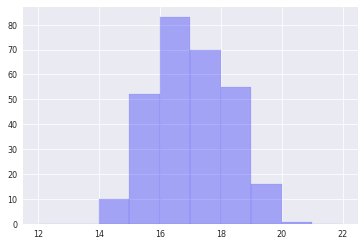

In [16]:
ret = plt.hist(data['ball_number'], bins=np.arange(12, 23), 
              color="#0000FF", edgecolor="#0000FF", alpha=0.3)
plt.savefig('choco_count_dist.png')

# パラメータ予測

In [11]:
# 事前分布のパラメータ$\alpha$
alpha = 1.0 / data['ball_number'].mean()

# ポアソン分布のパラメータ$\lmabda$の初期分布
lambda_1 = pm.Exponential("lambda_1", alpha)


In [12]:
# 観測データを結びつける
observation = pm.Poisson("obs", lambda_1, value=np.array(data['ball_number']), observed=True)
model = pm.Model([observation, lambda_1])

mcmc = pm.MCMC(model)
mcmc.sample(150000, 50000)

 [-----------------100%-----------------] 150000 of 150000 complete in 8.8 sec

In [13]:
lambda_1_sample = mcmc.trace('lambda_1')[:]

/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


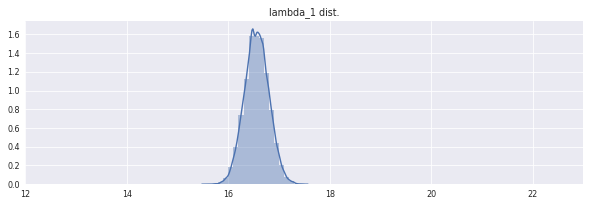

In [17]:
fig = plt.figure(figsize=(10, 3))
ax = fig.subplots(1, 1)

bs = np.arange(12, 23, 0.1)
sns.distplot(lambda_1_sample, ax=ax, bins=bs, label='lambda_1')
ax.set_xlim([12, 23])
ax.set_title('lambda_1 dist.')
fig.savefig('estimated_choco_count.png')

# 正規分布のパラメータを予測
## 最尤推定

In [ ]:
m = data['net_weight'].mean()
s = data['net_weight'].std()
print 'mean:{}, std:{}'.format(m, s)

## MCMCによるベイズ推定
### モデルの設定

In [ ]:
# 精度$\tau$(分散の逆数)
tau = 1.0 / pm.Uniform("std", 0, 100)**2

# 分布の中心
## 事前分布の中心として、製品仕様の28を、tauを0.01(分散=100)
center = pm.Normal("center", 28, 0.01)

# 観測とモデルを結びつける
observations = pm.Normal("obs", center, tau, value=data['net_weight'].values, observed=True)

# Modelオブジェクト生成
model = pm.Model([tau, center])

### mcmcの計算

In [ ]:
mcmc = pm.MCMC(model)
mcmc.sample(30000) # バーンイン無し

### MCMCの結果を確認

In [ ]:
center_trace = mcmc.trace("center")[:]
std_trace = mcmc.trace("std")[:]

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2,2,1)
plt.plot(center_trace, '.', alpha=0.3, label="center_trace")
plt.legend()

plt.subplot(2,2,2)
plt.plot(center_trace[10000:], '.', alpha=0.3, label="center_trace(10000~)")
plt.legend()

plt.subplot(2,2,3)
plt.plot(std_trace, '.', alpha=0.3, label="std_trace")
plt.legend()

plt.subplot(2,2,4)
plt.plot(std_trace[10000:], '.', alpha=0.3, label="std_trace(10000~)")
plt.legend()
#plt.savefig("trace_plot_net_weight.png")

上記の結果は、MCMCでのシミュレーションサンプルの系列を表している。
開始すぐに収束しているのがわかる。

In [ ]:
plt.figure(figsize=(12, 4))

# 平均の予測
plt.subplot(1,2,1)
ret = plt.hist(center_trace[10000:], bins=np.arange(28.0, 31.0, 0.1), 
               normed=True, label='distribution of mean')
# ret = plt.hist(center_trace[10000:], 
#                normed=True, label='distribution of mean')
plt.vlines(x=np.percentile(center_trace[10000:], 5), ymin=0, ymax=ret[0].max(), 
          colors='#00FF00', linewidth=2)
plt.vlines(x=np.percentile(center_trace[10000:], 95), ymin=0, ymax=ret[0].max(), 
          colors='#00FF00', linewidth=2)
plt.xlabel('net weight [g]')
plt.xlim([27.5, 31.5])
plt.legend()
print 'esetimate_center : {}'.format(center_trace[10000].mean())
print 'Bayesian credit section [5%~95%] : {}~{}'.format(
    np.percentile(center_trace[10000:], 5), np.percentile(center_trace[10000:], 95))
m_b = center_trace[10000].mean()

# 分散の予測
plt.subplot(1,2,2)
ret = plt.hist(std_trace[10000:], normed=True, label='distribution of std')
plt.xlabel('standard deviation of net_weight [g]')
plt.legend()
print 'estimate_std : {}'.format(std_trace.mean())
s_b = std_trace[10000:].mean()

plt.savefig('fig/estimated_dist_{}.png'.format(data.shape[0]))

# 予測結果を表示

In [ ]:
min_range=27.0
max_range=31.0
step=0.1
spec=28.0

b = np.arange(min_range, max_range, step)
ret = plt.hist(data['net_weight'], 
               bins=b, color="#0000FF", alpha=0.5, edgecolor="#0000FF", 
               label='measure', normed=True)
plt.vlines(x=spec, ymin=0, ymax=ret[0].max(), 
           colors='#FF0000', linewidths=2, label='spec')

# 最尤推定パラメータの分布
x = np.linspace(min_range, max_range, 300)
y = stats.norm.pdf(x, loc=m, scale=s)
plt.plot(x, y, lw=3, color='#0000FF', label='MLE')

# ベイズ推定での分布
y = stats.norm.pdf(x, loc=m_b, scale=s_b)
plt.plot(x, y, lw=3, color='#FF00FF', label='Bayes')

plt.legend()
plt.xlabel('net weight [g]')
plt.ylabel('probability density')

plt.savefig('fig/weight_distribution_{}.png'.format(data.shape[0]))